<a href="https://colab.research.google.com/github/alexanderportilla96/Sy2025II/blob/main/Copia_de_Solucion_parcial_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.0/180.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 33.4 MB/s eta 0:00:00
--- Iniciando descarga de: https://www.youtube.com/watch?v=VPRjCeoBqrI ---


Señal adquirida: Fs=48000Hz, Muestras=240000


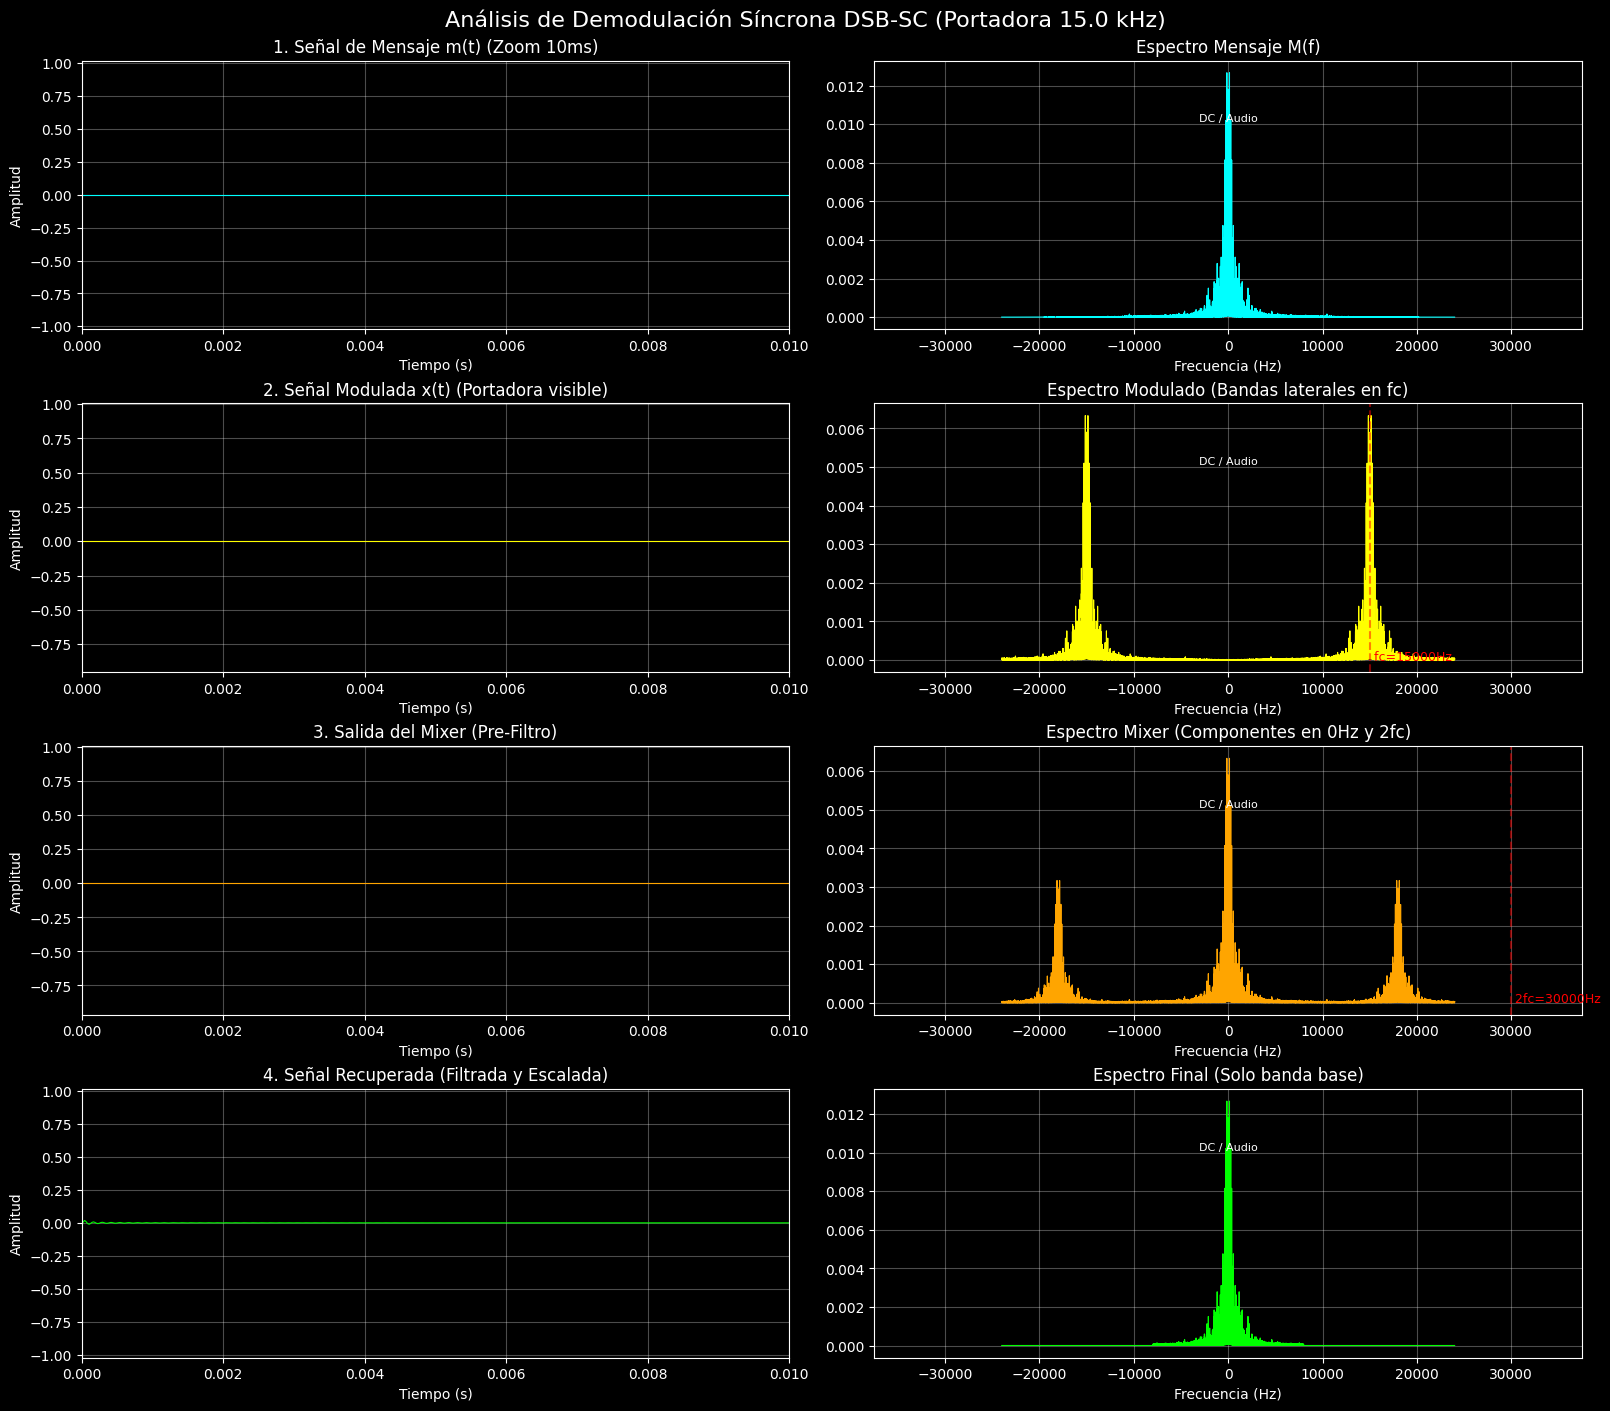

Proceso finalizado. Verifica las gráficas para validar el espectro.


In [1]:
# !pip install yt_dlp numpy matplotlib scipy
!pip install yt_dlp
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
import yt_dlp
import os

# ==========================================
# 1. PARÁMETROS DE INGENIERÍA Y DISEÑO
# ==========================================
DURATION = 5.0        # Segundos de audio a procesar
FC = 15000            # Frecuencia portadora (Hz).
                      # NOTA: Debe ser > ancho de banda del audio.
                      # Si fs=44100, fc=15k está al límite, pero funciona para visualizar.
A1 = 1.0              # Amplitud de la portadora
THETA = 0             # Fase del oscilador (sincronizada)
LOWER_CUTOFF = 8000   # Frecuencia de corte del filtro LPF (Hz)

# ==========================================
# 2. ADQUISICIÓN DE SEÑAL (YouTube)
# ==========================================
def get_audio_signal(youtube_url):
    print(f"--- Iniciando descarga de: {youtube_url} ---")

    # Configuración para descargar audio en la mejor calidad posible
    ydl_opts = {
        'format': 'bestaudio/best',
        'postprocessors': [{
            'key': 'FFmpegExtractAudio',
            'preferredcodec': 'wav',
            'preferredquality': '192',
        }],
        'outtmpl': 'input_audio.%(ext)s',
        'quiet': True
    }

    # Intentar descargar
    if not os.path.exists("input_audio.wav"):
        try:
            with yt_dlp.YoutubeDL(ydl_opts) as ydl:
                ydl.download([youtube_url])
        except Exception as e:
            print(f"Advertencia: No se pudo descargar ({e}). Generando tono de prueba.")
            fs_dummy = 44100
            t_dummy = np.linspace(0, DURATION, int(DURATION*fs_dummy))
            return np.sin(2*np.pi*440*t_dummy) * 0.5, fs_dummy

    # Leer archivo WAV
    fs, data = wav.read("input_audio.wav")

    # Procesamiento de señal: Estéreo a Mono y Normalización
    if len(data.shape) > 1:
        data = np.mean(data, axis=1) # Promedio de canales

    # Normalizar entre -1 y 1 (Buenas prácticas de DSP)
    data = data / np.max(np.abs(data))

    # Recortar duración
    num_samples = int(DURATION * fs)
    if len(data) > num_samples:
        data = data[:num_samples]

    print(f"Señal adquirida: Fs={fs}Hz, Muestras={len(data)}")
    return data, fs

# Obtener señal
url_coldplay = "https://www.youtube.com/watch?v=VPRjCeoBqrI"
m_t, fs = get_audio_signal(url_coldplay)
N = len(m_t)
t = np.arange(N) / fs
f = np.fft.fftfreq(N, 1/fs) # Eje de frecuencias para plots y filtro

# ==========================================
# 3. IMPLEMENTACIÓN DEL SISTEMA (Modulación y Demodulación)
# ==========================================

# --- ETAPA 1: MODULACIÓN (Transmisor) ---
# Ecuación: x(t) = A1 * m(t) * cos(2*pi*fc*t + theta)
carrier = np.cos(2 * np.pi * FC * t + THETA)
x_t = A1 * m_t * carrier

# --- ETAPA 2: DEMODULACIÓN - MIXER ---
# Ecuación: y(t) = x(t) * cos(2*pi*fc*t + theta)
# Esto traslada el espectro de nuevo a banda base (0Hz) y a 2*fc
mixer_out = x_t * carrier

# --- ETAPA 3: FILTRADO (LPF via FFT) ---
# Requisito del ejercicio: Usar FFT para filtrar.
# 1. Transformar al dominio de la frecuencia
Y_f = np.fft.fft(mixer_out)

# 2. Crear máscara (Filtro Ideal / Brick-wall)
# Pasamos solo frecuencias donde |f| < cutoff
mask = np.abs(f) < LOWER_CUTOFF
Z_f = Y_f * mask

# 3. Transformada Inversa (volver al tiempo)
z_t = np.real(np.fft.ifft(Z_f))

# --- ETAPA 4: ESCALADO (Amplificador) ---
# Recuperar amplitud original. Teoría: Mixer atenúa por 1/2 * A1
scaling_factor = 2 / A1
m_recuperada = z_t * scaling_factor

# ==========================================
# 4. VISUALIZACIÓN (Dashboard de Ingeniería)
# ==========================================
plt.style.use('dark_background') # Estilo "Osciloscopio"
fig, ax = plt.subplots(4, 2, figsize=(16, 14), constrained_layout=True)
fig.suptitle(f'Análisis de Demodulación Síncrona DSB-SC (Portadora {FC/1000} kHz)', fontsize=16)

def plot_signal_system(row_idx, time_sig, title_time, title_freq, color):
    # Dominio del Tiempo
    ax[row_idx, 0].plot(t, time_sig, color=color, linewidth=0.8)
    ax[row_idx, 0].set_title(title_time)
    ax[row_idx, 0].set_xlabel("Tiempo (s)")
    ax[row_idx, 0].set_ylabel("Amplitud")
    ax[row_idx, 0].set_xlim([0, 0.01]) # ZOOM de 10ms para ver la onda
    ax[row_idx, 0].grid(True, alpha=0.3)

    # Dominio de la Frecuencia (FFT)
    # Usamos fftshift para centrar 0Hz en el medio
    SPEC = np.fft.fftshift(np.abs(np.fft.fft(time_sig))/N)
    FREQ = np.fft.fftshift(f)

    ax[row_idx, 1].plot(FREQ, SPEC, color=color, linewidth=0.8)
    ax[row_idx, 1].set_title(title_freq)
    ax[row_idx, 1].set_xlabel("Frecuencia (Hz)")
    ax[row_idx, 1].set_xlim([-FC*2.5, FC*2.5]) # Ver hasta un poco más allá de 2*fc
    ax[row_idx, 1].grid(True, alpha=0.3)

    # Anotación de picos clave
    max_f = FREQ[np.argmax(SPEC)]
    ax[row_idx, 1].text(0, np.max(SPEC)*0.8, "DC / Audio", ha='center', color='white', fontsize=8)

# 1. Mensaje Original
plot_signal_system(0, m_t, "1. Señal de Mensaje m(t) (Zoom 10ms)", "Espectro Mensaje M(f)", 'cyan')

# 2. Modulada
plot_signal_system(1, x_t, "2. Señal Modulada x(t) (Portadora visible)", "Espectro Modulado (Bandas laterales en fc)", 'yellow')
# Agregar marca en fc
ax[1, 1].axvline(x=FC, color='red', linestyle='--', alpha=0.5)
ax[1, 1].text(FC, 0, f" fc={FC}Hz", color='red', fontsize=9)

# 3. Salida Mixer
plot_signal_system(2, mixer_out, "3. Salida del Mixer (Pre-Filtro)", "Espectro Mixer (Componentes en 0Hz y 2fc)", 'orange')
# Agregar marca en 2fc
ax[2, 1].axvline(x=2*FC, color='red', linestyle='--', alpha=0.5)
ax[2, 1].text(2*FC, 0, f" 2fc={2*FC}Hz", color='red', fontsize=9)

# 4. Recuperada Final
plot_signal_system(3, m_recuperada, "4. Señal Recuperada (Filtrada y Escalada)", "Espectro Final (Solo banda base)", 'lime')

plt.show()

# ==========================================
# 5. VALIDACIÓN AUDITIVA (Opcional)
# ==========================================
# Descomentar para guardar el audio resultante
# wav.write("salida_recuperada.wav", fs, m_recuperada.astype(np.float32))
print("Proceso finalizado. Verifica las gráficas para validar el espectro.")